In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall -y sympy
!pip install sympy==1.12

Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system 

In [3]:
import os

os.chdir('/content/drive/My Drive/split_dataset') #切換該目錄
os.listdir() #確認目錄內容

['.DS_Store', 'test', 'val', 'train']

In [4]:
train_folder = '/content/drive/My Drive/split_dataset/train'
val_folder = '/content/drive/My Drive/split_dataset/val'
test_folder = '/content/drive/My Drive/split_dataset/test'

In [5]:
import os
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class FeatureSequenceDataset(Dataset):
    def __init__(self, root_path, exclude_labels=None):
        self.paths = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        exclude_labels = exclude_labels or []

        for class_name in sorted(os.listdir(root_path)):
            if class_name in exclude_labels:
                continue

            class_path = os.path.join(root_path, class_name)
            if not os.path.isdir(class_path):
                continue

            for fname in os.listdir(class_path):
                if fname.endswith(".pt"):
                    self.paths.append(os.path.join(class_path, fname))
                    self.labels.append(class_name)

        self.labels = self.label_encoder.fit_transform(self.labels)
        self.num_classes = len(self.label_encoder.classes_)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        pt_path = self.paths[idx]
        item = torch.load(pt_path)
        x = item["feature"]  # [16, 512]
        y = self.labels[idx] # int
        return x, y


In [18]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

train_set = FeatureSequenceDataset(train_folder, exclude_labels=["unknown"])
val_set   = FeatureSequenceDataset(val_folder, exclude_labels=["unknown"])
test_set  = FeatureSequenceDataset(test_folder, exclude_labels=["unknown"])

test_set_small = Subset(test_set, range(100))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_set_small, batch_size=32, shuffle=False)

print("Classes:", train_set.label_encoder.classes_)
print("Train samples:", len(train_set))
print("Val samples:", len(val_set))
print("Test samples:", len(test_set))

print("test loader:", len(test_loader))


Classes: ['lateral' 'leave_to_left' 'leave_to_right' 'moving_ahead_or_waiting'
 'normal' 'obstacle' 'oncoming' 'pedestrian' 'start_stop_or_stationary'
 'turning']
Train samples: 4221
Val samples: 526
Test samples: 531
test loader: 4


In [19]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, num_layers=1, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out


In [20]:
import torch
from tqdm import tqdm
from tqdm import tqdm
import sympy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = LSTMClassifier(num_classes=train_set.num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



cpu


In [ ]:

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (pred.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} Train Loss: {total_loss:.4f}, Acc: {acc:.4f}")

    # 驗證
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            val_loss += loss.item()
            val_correct += (pred.argmax(dim=1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1} Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


cpu


[Train] Epoch 1: 100%|██████████| 91/91 [16:38<00:00, 10.97s/it]


Epoch 1 Train Loss: 162.7658, Acc: 0.3639
Epoch 1 Val   Loss: 20.6694, Acc: 0.3823


[Train] Epoch 2: 100%|██████████| 91/91 [00:20<00:00,  4.50it/s]


Epoch 2 Train Loss: 153.4341, Acc: 0.3984
Epoch 2 Val   Loss: 20.2246, Acc: 0.3961


[Train] Epoch 3: 100%|██████████| 91/91 [00:20<00:00,  4.40it/s]


Epoch 3 Train Loss: 148.8652, Acc: 0.4264
Epoch 3 Val   Loss: 20.1974, Acc: 0.3989


[Train] Epoch 4: 100%|██████████| 91/91 [00:21<00:00,  4.17it/s]


Epoch 4 Train Loss: 145.8074, Acc: 0.4357
Epoch 4 Val   Loss: 20.5811, Acc: 0.3767


[Train] Epoch 5: 100%|██████████| 91/91 [00:19<00:00,  4.62it/s]


Epoch 5 Train Loss: 144.5103, Acc: 0.4292
Epoch 5 Val   Loss: 20.4072, Acc: 0.3934


[Train] Epoch 6: 100%|██████████| 91/91 [00:19<00:00,  4.71it/s]


Epoch 6 Train Loss: 140.6212, Acc: 0.4537
Epoch 6 Val   Loss: 20.2627, Acc: 0.4017


[Train] Epoch 7: 100%|██████████| 91/91 [00:19<00:00,  4.63it/s]


Epoch 7 Train Loss: 137.8531, Acc: 0.4572
Epoch 7 Val   Loss: 20.2974, Acc: 0.4017


[Train] Epoch 8: 100%|██████████| 91/91 [00:19<00:00,  4.70it/s]


Epoch 8 Train Loss: 135.5094, Acc: 0.4727
Epoch 8 Val   Loss: 20.0334, Acc: 0.3934


[Train] Epoch 9: 100%|██████████| 91/91 [00:19<00:00,  4.70it/s]


Epoch 9 Train Loss: 133.3826, Acc: 0.4744
Epoch 9 Val   Loss: 20.5944, Acc: 0.3795


[Train] Epoch 10: 100%|██████████| 91/91 [00:19<00:00,  4.58it/s]


Epoch 10 Train Loss: 132.5457, Acc: 0.4782
Epoch 10 Val   Loss: 20.2442, Acc: 0.4044


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/lstm_classifier.pt")

In [22]:
model.eval()
test_correct, test_total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        preds = pred.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {test_correct / test_total:.4f}")


Test Accuracy: 0.0300


<Figure size 1000x800 with 0 Axes>

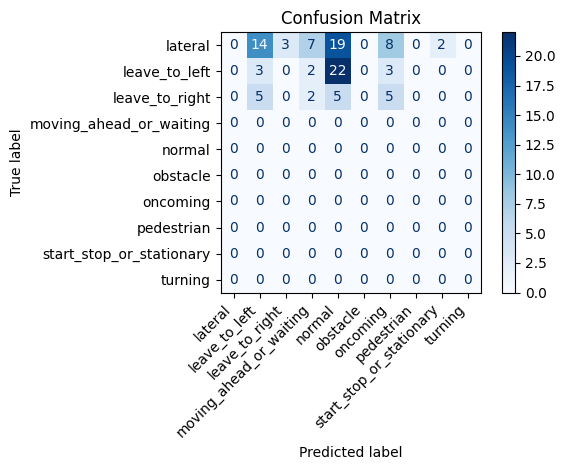

<Figure size 640x480 with 0 Axes>

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = test_set.label_encoder.classes_  # 保留所有類別名稱
num_classes = len(class_names)
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

plt.figure(figsize=(10, 8))  # ✅ 加大畫布
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

plt.xticks(rotation=45, ha='right')  # ✅ 旋轉字
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()                   # ✅ 自動排版避免壓縮
plt.show()
plt.savefig('/content/drive/My Drive/lstm_confusion_matrix.png')


In [28]:
from sklearn.metrics import classification_report

class_names = test_set.label_encoder.classes_  # e.g., 10 個類別
num_classes = len(class_names)
labels = list(range(num_classes))              # 保證使用完整類別

report = classification_report(
    all_labels,
    all_preds,
    labels=labels,               # ✅ 指定所有類別 index
    target_names=class_names,    # ✅ 對應 class 名稱
    digits=4                     # 可選：顯示小數點後 4 位
)

print(report)


                          precision    recall  f1-score   support

                 lateral     0.0000    0.0000    0.0000        53
           leave_to_left     0.1364    0.1000    0.1154        30
          leave_to_right     0.0000    0.0000    0.0000        17
 moving_ahead_or_waiting     0.0000    0.0000    0.0000         0
                  normal     0.0000    0.0000    0.0000         0
                obstacle     0.0000    0.0000    0.0000         0
                oncoming     0.0000    0.0000    0.0000         0
              pedestrian     0.0000    0.0000    0.0000         0
start_stop_or_stationary     0.0000    0.0000    0.0000         0
                 turning     0.0000    0.0000    0.0000         0

                accuracy                         0.0300       100
               macro avg     0.0136    0.0100    0.0115       100
            weighted avg     0.0409    0.0300    0.0346       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me